# PEC1 - Generative Adversarial Networks
A partir del conjunto de datos CIFAR10, se debe entrenar una *DCGAN* (*Deep Convolutional Generative Adversarial Network*) para generar nuevas imágenes. Una vez implementada la red, se deberá agregar *experience replay* y comparar los resultados con los obtenidos en la red inicial. Por último, se deberá convertir la red en una GAN condicional.

## Esquema de la plantilla
El esquema de la memoria deberá ser el siguiente:

1. Explicar qué es una *DCGAN* y cómo funciona (haciendo énfasis en explicar las dos partes principales de este tipo de modelos)
1. Describir brevemente el conjunto de datos inicial (*CIFAR10*)
1. Entrenar una *DCGAN (Deep Convolutional Generative Adversarial Network)* para generar imágenes.
1. Añadir *experience replay*
1. Convertir la red a una *GAN condicional*

En primer lugar vamos a cargar las librerías y funciones de apoyo que se van a utilizar en el código del cuadernillo. Si se quiere utilizar alguna librería adicional se puede añadir dicha librería en este punto o en la celda de código en la que se vaya a utilizar por primera vez.


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
assert tf.__version__ >= "2.0"
from tensorflow import keras

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Reshape, Conv2D, BatchNormalization, Conv2DTranspose, LeakyReLU, Flatten, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam

import sklearn
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# Check for GPU
!nvidia-smi

print("GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Sun Apr 21 01:17:00 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Consideraciones iniciales

Dado el tiempo de cómputo que exigen este tipo de redes se limitará el análisis de 50 epochs. Es muy recomendable, también que, si no se dispone de una tarjeta gráfica y una configuración compatible con tensorflow (puede comprobarse con la última salida del bloque anterior, si el número de GPUs disponible es 0) se utilice para la realización de esta práctica Google Colab. En este plataforma deberemos configurar el entorno de ejecución para que soporte GPUs, esto puede hacerse a través del menú *Entorno de ejecución* y la opción *Cambiar tipo de entorno de ejecución*, selecconando **GPU** como *Acelerador por hardware* .

In [ ]:
# Definimos las constantes que utilizaremos a lo largo del cuadernillo
batch_size = 128
epochs = 50
latent_dim = 100

Es importante saber que para poder depurar algunos métodos como «fit» debemos cambiar el modo de ejecución. Para ello podemos dar el valor «True» al parámetro «run_eagerly» cuando compilemos el modelo. Cuidado, al cambiar este parámetro la ejecución del código será mucho más lenta. Para más información y consejos de depuración se recomienda utilizar los consejos que se indican en la propia página de Keras (https://keras.io/examples/keras_recipes/debugging_tips/)

## Memoria
**Nombre:** <mark>Gregory Anthony Turri</mark>

**Correo UNED:** <mark>gturri1@alumno.uned.es</mark>

### ¿Qué es una DCGAN?
<mark>\[Respuesta: Explicar lo que es una DCGAN, extensión aproximada de 2 párrafos (200 palabras) \]</mark>


### CIFAR10
<mark>\[Respuesta: Describir brevemente el conjunto de datos CIFAR10, puede utilizar celdas de código para apoyarse en la descripción\]</mark>

In [ ]:
# En primer lugar vamos a descargar el conjunto de datos
(X_train, Y_train), (X_test, Y_test) = keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 3s 0us/step


In [ ]:
# INICIO_RESPUESTA 0/7
# Requisitos: De como valor de la variable «semilla_aleatoria» los últimos dos dígitos de su documento de identificación
semilla_aleatoria = 12
# FIN_RESPUESTA

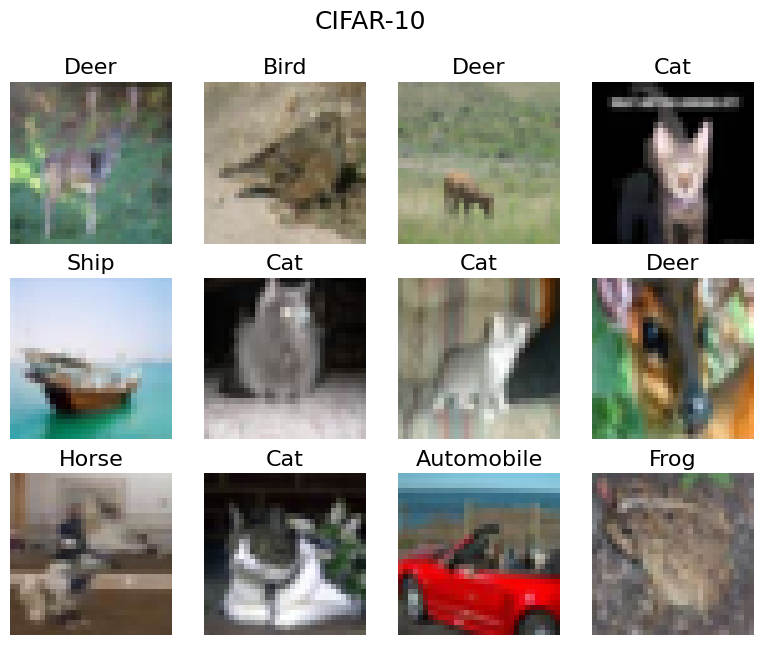

In [ ]:
np.random.seed(semilla_aleatoria)
tf.random.set_seed(semilla_aleatoria)

# Vamos a visualizar un subconjunto de las imagenes que hemos cargado
clases = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
plt.figure(figsize=(9.6,7.2))
plt.suptitle("CIFAR-10", size=18)
plt.subplots_adjust(wspace=0.2)

pos = 1
for n in np.random.randint(low=0,high=len(X_train),size=12):
    plt.subplot(3, 4, pos)
    plt.imshow(X_train[n])
    plt.axis('off')
    plt.title(clases[Y_train[n][0]], size=16)
    pos += 1
plt.show()

### Pre-procesado de datos
<mark>\[Respuesta: Describir los pasos de preprocesado que se han realizado así como la justificación de los mismos (tener en cuenta que se utilizará la función de activación tangencial hipèrbólica)\]</mark>

Como se usa la función de activación *tanh*, cuyo rango es [-1, 1], se elige normalizar los valores de las imágenes de entrada. De este modo se mejora la estabilidad de la red durante el entrenamiento, y se mejora el rendimiento de la misma.

In [ ]:
# Dado que no tendremos una estructura de entrenamiento y validación, vamos a juntar todos las imágenes
all_imgs = np.concatenate([X_train, X_test])
all_labels = np.concatenate([Y_train, Y_test])

# INICIO_RESPUESTA 1/7
# Requisitos: Realice el pre-procesado de los datos de entrada teniendo en cuenta las recomendaciones que se indican en el capítulo 17 del libro, guarde el resultado en all_imgs.
all_imgs = (all_imgs.astype('float32') - 127.5)/127.5
# FIN_RESPUESTA

Al normalizarse los valores de entrada, una imágen pasa de tener pixeles con valores entre [0, 255] a [-1, 1]

In [ ]:
print(all_imgs.min())
print(all_imgs.mean())
print(all_imgs.max())

-1.0
-0.052200183
1.0


### DCGAN Inicial
En este apartado se quiere crear una primera red usando la API secuencial de Keras.  Es importante en este punto revisar las recomendaciones que se presentan en el capítulo 17 del libro:

<mark>\[Respuesta: Describir las recomendaciones que se presentan en el capítulo 17 del libro. Si, tras la evaluación de estas recomendaciones se detectan inconsistencias o no se siguen todas, indicar por qué.\]</mark>



Las recomendaciones que se presentan el en capítulo 17 del libro para construir una *DCGAN* son:
1. Reemplazar las capas de agrupación con convoluciones escalonadas (en el discriminador) y convoluciones transpuestas (en el generador).
2. Utilizar la normalización por lotes tanto en el generador como en el discriminador, excepto en la capa de salida del generador y en la capa de entrada del discriminador.
3. Eliminar las capas ocultas completamente conectadas para obtener arquitecturas más profundas.
4. Utilizar la activación ReLU en el generador para todas las capas excepto la capa de salida, que debería utilizar tanh.
5. Utilizar activación ReLU con fugas en el discriminador para todas las capas.

#### Generador

Para el generador se utilizará la siguiente estructura:

1. Capa densa y reshape a 8 x 8 x 128
2. Capa de convolución transpuesta con 64 filtros (kernel de 4x4, 2 strides y padding 'same')
3. Capa de convolución transpuesta con 64 filtros (kernel de 4x4, 2 strides y padding 'same')
4. Capa convolucional con 3 filtros (kernel de 3x3, 1 stride, padding 'same' y función de activación 'tanh')

Todas las capas convolucionales transpuestas tienen una función de activación Leaky ReLU (únicamente las transpuestas) y, tras cada capa se aplicará normalización por lotes (BatchNormalization).

In [ ]:
generator = keras.models.Sequential([
    keras.layers.Input(shape=(100,)),

# INICIO_RESPUESTA 2/7
# Requisitos: Añada las capas indicadas para el generador
    tf.keras.layers.Dense(8 * 8 * 128),
    tf.keras.layers.Reshape([8, 8, 128]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(3,  kernel_size=3, strides=1, padding="same", activation="tanh"),
# FIN_RESPUESTA
])

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8192)              827392    
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 batch_normalization (Batch  (None, 8, 8, 128)         512       
 Normalization)                                                  
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 64)        131136    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 16, 16, 64)        256       
 chNormalization)                                                
                                                        

#### Discriminador

Para el Discriminador se utilizará la siguiente estructura:

1. Capa convolucional con 32 filtros (kernel de 4x4, 2 strides y padding 'same')
2. Capa convolucional con 64 filtros (kernel de 4x4, 2 strides y padding 'same')
3. Capa convolucioanl con 128 filtros (kernel de 4x4, 2 strides y padding 'same')
4. Capa Densa con función de activación sigmoide

Todas las capas convolucionales tienen una función de activación Leaky ReLU y, posteriormente se aplicarán normalización (BatchNormalization) y Dropout. Salvo la última capa convolucional que no aplicará normalización si no que aplanará el resultado de cara a la última capa densa.

In [ ]:
discriminator = keras.models.Sequential([
# INICIO_RESPUESTA 3/7
# Requisitos: Añada las capas indicadas para el discriminador
  tf.keras.layers.Conv2D(32, kernel_size=4, strides=2, padding="same",activation=tf.keras.layers.LeakyReLU(0.2)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Conv2D(64, kernel_size=4, strides=2, padding="same",activation=tf.keras.layers.LeakyReLU(0.2)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Conv2D(128, kernel_size=4, strides=2, padding="same",activation=tf.keras.layers.LeakyReLU(0.2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation="sigmoid")
# FIN_RESPUESTA
])

# discriminator.summary() # Se comenta esta linea porque da un error, ya que el modelo necesita ser construido para poder invocar este metodo.

#### Modelo
<mark>\[Respuesta: Explicar los pasos de entrenamiento de una GAN, diferenciando el proceso de entrenamiento del generador y del discriminador. \]</mark>

In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):

        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        generated_images = self.generator(random_latent_vectors)

        combined_images = tf.concat([generated_images, real_images], axis=0)

        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)

        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=100, show_range=10, enable_show=True, enable_save=False):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.show_range = show_range
        self.enable_show = enable_show
        self.enable_save = enable_save

    def on_epoch_end(self, epoch, logs=None):
        if ((epoch+1) % self.show_range) == 0 or epoch == 0:
          random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
          generated_images = self.model.generator(random_latent_vectors)
          generated_images += 1
          generated_images /= 2

          generated_images.numpy()
          plt.figure(figsize=(self.num_img, 1))
          for i in range(self.num_img):
              img = keras.preprocessing.image.array_to_img(generated_images[i])
              if self.enable_show:
                plt.subplot(1, self.num_img, i + 1)
                plt.imshow(img, cmap="binary")
                plt.axis("off")
              if self.enable_save:
                img.save("generated_img_%03d_%d.png" % (epoch, i))
          if self.enable_show:
            plt.show()

In [ ]:
def plt_loss(history):
    '''
    Función que nos ayudará a visualizar la evolución de las pérdidas del generador y del discriminador
    '''
    f_num = "{:.3f}"
    plt.figure(figsize=(12,5))
    plt.suptitle("Función de pérdida", size=18)
    plt.subplots_adjust(wspace=0.5, hspace = 0.5)
    plt.subplot(1, 2, 1)
    plt.plot(history.history['d_loss'])
    plt.title("Discriminador")
    plt.ylabel('Loss')
    plt.xlabel('Epoch')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['g_loss'])
    plt.title("Generador")
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.tight_layout(pad=4)
    plt.show()
    print(f"Pérdida discriminador: Min ({f_num.format(np.min(history.history['d_loss']))}) Max ({f_num.format(np.max(history.history['d_loss']))}) Media ({f_num.format(np.mean(history.history['d_loss']))})")
    print(f"Pérdida generador: Min ({f_num.format(np.min(history.history['g_loss']))}) Max ({f_num.format(np.max(history.history['g_loss']))}) Media ({f_num.format(np.mean(history.history['g_loss']))})")

#### Optimizadores y función de pérdida
<mark>\[Respuesta: Explicar qué optimizadores se utilizarán para el discriminador y el generador y por qué. \]</mark>

In [ ]:
# INICIO_RESPUESTA 4/7
# Requisitos: Inicialice los optimizadores que se utilizarán para el discriminador y para el generador, se aconseja utilizar valores LR de aproximadamente 0.0002
d_optimizer = Adam(learning_rate=0.0002)
g_optimizer = Adam(learning_rate=0.0002)
# FIN_RESPUESTA

loss_fn = keras.losses.BinaryCrossentropy()

Epoch 1/50
467/468 [============================>.] - ETA: 0s - d_loss: 0.4342 - g_loss: 2.2710

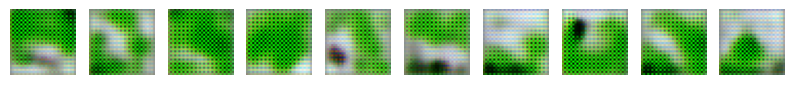

468/468 [==============================] - 21s 27ms/step - d_loss: 0.4336 - g_loss: 2.2731
Epoch 2/50
468/468 [==============================] - 13s 27ms/step - d_loss: 0.5260 - g_loss: 1.9069
Epoch 3/50
468/468 [==============================] - 13s 27ms/step - d_loss: 0.5100 - g_loss: 1.8128
Epoch 4/50
468/468 [==============================] - 12s 27ms/step - d_loss: 0.5466 - g_loss: 1.5118
Epoch 5/50
468/468 [==============================] - 12s 26ms/step - d_loss: 0.5756 - g_loss: 1.7814
Epoch 6/50
468/468 [==============================] - 12s 26ms/step - d_loss: 0.5453 - g_loss: 1.3363
Epoch 7/50
468/468 [==============================] - 12s 27ms/step - d_loss: 0.6139 - g_loss: 1.2772
Epoch 8/50
468/468 [==============================] - 12s 27ms/step - d_loss: 0.5765 - g_loss: 1.3584
Epoch 9/50
468/468 [==============================] - 12s 27ms/step - d_loss: 0.5928 - g_loss: 1.3437
Epoch 10/50
467/468 [============================>.] - ETA: 0s - d_loss: 0.6415 - g_loss: 1.3

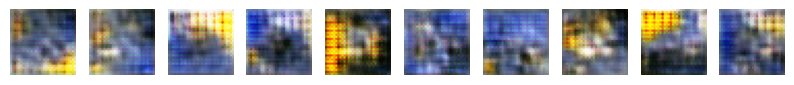

468/468 [==============================] - 13s 27ms/step - d_loss: 0.6412 - g_loss: 1.3767
Epoch 11/50
468/468 [==============================] - 12s 26ms/step - d_loss: 0.6144 - g_loss: 1.1841
Epoch 12/50
468/468 [==============================] - 12s 26ms/step - d_loss: 0.6030 - g_loss: 1.2746
Epoch 13/50
468/468 [==============================] - 12s 26ms/step - d_loss: 0.5569 - g_loss: 1.6706
Epoch 14/50
468/468 [==============================] - 12s 27ms/step - d_loss: 0.5758 - g_loss: 1.3775
Epoch 15/50
468/468 [==============================] - 13s 27ms/step - d_loss: 0.6153 - g_loss: 1.1082
Epoch 16/50
468/468 [==============================] - 12s 27ms/step - d_loss: 0.5713 - g_loss: 1.3796
Epoch 17/50
468/468 [==============================] - 12s 26ms/step - d_loss: 0.5961 - g_loss: 1.7168
Epoch 18/50
468/468 [==============================] - 12s 26ms/step - d_loss: 0.5961 - g_loss: 1.2501
Epoch 19/50
468/468 [==============================] - 12s 26ms/step - d_loss: 0.6158

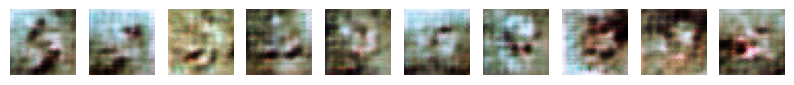

468/468 [==============================] - 13s 27ms/step - d_loss: 0.6036 - g_loss: 1.1737
Epoch 21/50
468/468 [==============================] - 12s 26ms/step - d_loss: 0.6019 - g_loss: 1.3507
Epoch 22/50
468/468 [==============================] - 13s 27ms/step - d_loss: 0.6068 - g_loss: 1.2824
Epoch 23/50
468/468 [==============================] - 12s 26ms/step - d_loss: 0.6387 - g_loss: 1.5105
Epoch 24/50
468/468 [==============================] - 12s 26ms/step - d_loss: 0.5909 - g_loss: 1.2050
Epoch 25/50
468/468 [==============================] - 12s 27ms/step - d_loss: 0.6400 - g_loss: 1.0679
Epoch 26/50
468/468 [==============================] - 12s 26ms/step - d_loss: 0.6180 - g_loss: 1.2184
Epoch 27/50
468/468 [==============================] - 12s 26ms/step - d_loss: 0.6193 - g_loss: 1.1451
Epoch 28/50
468/468 [==============================] - 12s 27ms/step - d_loss: 0.6285 - g_loss: 1.1071
Epoch 29/50
468/468 [==============================] - 14s 30ms/step - d_loss: 0.6353

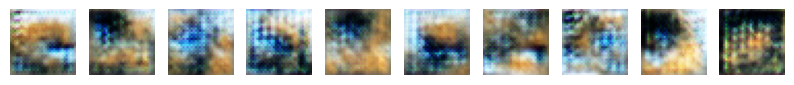

468/468 [==============================] - 13s 28ms/step - d_loss: 0.5865 - g_loss: 1.5244
Epoch 31/50
468/468 [==============================] - 12s 27ms/step - d_loss: 0.5900 - g_loss: 1.2172
Epoch 32/50
468/468 [==============================] - 12s 26ms/step - d_loss: 0.5710 - g_loss: 1.4395
Epoch 33/50
468/468 [==============================] - 12s 26ms/step - d_loss: 0.6106 - g_loss: 1.3115
Epoch 34/50
468/468 [==============================] - 13s 27ms/step - d_loss: 0.6092 - g_loss: 1.1426
Epoch 35/50
468/468 [==============================] - 12s 26ms/step - d_loss: 0.6395 - g_loss: 1.2810
Epoch 36/50
468/468 [==============================] - 12s 26ms/step - d_loss: 0.6118 - g_loss: 1.4589
Epoch 37/50
468/468 [==============================] - 12s 27ms/step - d_loss: 0.5851 - g_loss: 1.2209
Epoch 38/50
468/468 [==============================] - 13s 27ms/step - d_loss: 0.6191 - g_loss: 1.2200
Epoch 39/50
468/468 [==============================] - 13s 27ms/step - d_loss: 0.6066

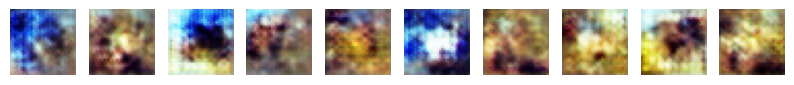

468/468 [==============================] - 13s 27ms/step - d_loss: 0.6519 - g_loss: 1.0291
Epoch 41/50
468/468 [==============================] - 14s 29ms/step - d_loss: 0.6362 - g_loss: 0.9780
Epoch 42/50
468/468 [==============================] - 13s 27ms/step - d_loss: 0.6209 - g_loss: 1.1858
Epoch 43/50
468/468 [==============================] - 12s 26ms/step - d_loss: 0.6184 - g_loss: 1.1905
Epoch 44/50
468/468 [==============================] - 12s 26ms/step - d_loss: 0.6203 - g_loss: 1.1797
Epoch 45/50
468/468 [==============================] - 12s 26ms/step - d_loss: 0.6352 - g_loss: 1.1646
Epoch 46/50
468/468 [==============================] - 12s 27ms/step - d_loss: 0.6573 - g_loss: 1.0948
Epoch 47/50
468/468 [==============================] - 12s 27ms/step - d_loss: 0.6362 - g_loss: 0.9900
Epoch 48/50
468/468 [==============================] - 12s 26ms/step - d_loss: 0.6302 - g_loss: 1.0406
Epoch 49/50
468/468 [==============================] - 12s 27ms/step - d_loss: 0.6080

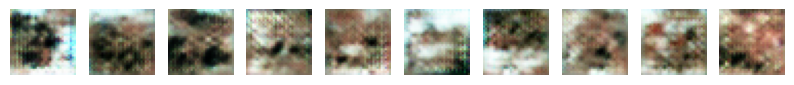

468/468 [==============================] - 13s 27ms/step - d_loss: 0.6265 - g_loss: 1.0572


In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(all_imgs).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=d_optimizer,
    g_optimizer=g_optimizer,
    loss_fn=loss_fn,
)

history = gan.fit(dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)])

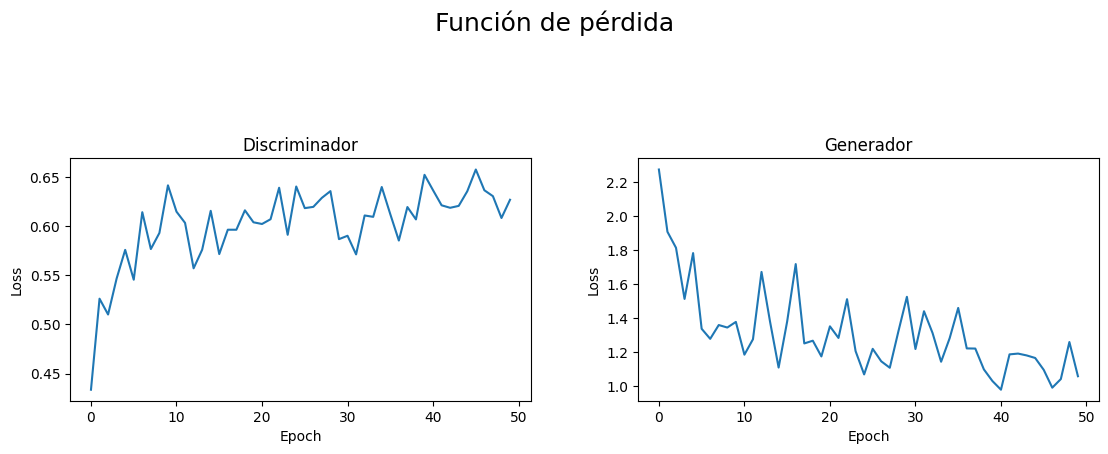

Pérdida discriminador: Min (0.434) Max (0.657) Media (0.601)
Pérdida generador: Min (0.978) Max (2.273) Media (1.313)


In [ ]:
plt_loss(history)

#### Resultados
<mark>\[Respuesta: Explicar los resultados obtenidos visualizando la evolución de las pérdidas del discriminador y del generador. \]</mark>

### Experience replay
<mark>\[Respuesta: Explicar en qué consiste la técnica de *Experience replay* y qué resultados se esperan de su uso. \]</mark>


<mark>\[Respuesta: Explicar qué estrategia de *Experience replay* (de las muchas posibles) se ha implementado en el modelo que hay a continuación. \]</mark>

#### Modelo

In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim, semilla_aleatoria):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.experience_replay = []
        self.semilla_aleatoria = semilla_aleatoria

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")
        # self.run_eagerly = True

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):

        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        generated_images = self.generator(random_latent_vectors)

        combined_images = tf.concat([generated_images, real_images], axis=0)

        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # INICIO_RESPUESTA 5/7
        # Requisitos: Implementar una estrategia de Experience replay a partir de un buffer de imágenes alamacenadas en cada iteración
        self.experience_replay.append(generated_images)
        if len(self.experience_replay) >= 10: # significa 10 steps, es decir, 10 batches = 10*128=1280 images
            # Convertimos la lista a un tensor de dimension 1280 x 32 x 32 x 3
            old_generated_images = tf.concat(self.experience_replay, axis=0)
            # Elegimos un 10% aleatorio (128 de 1280) de este buffer --> Se usa como "imagenes generadas" para esta ronda
            random_indices = tf.random.uniform((128,), minval=0, maxval=128, dtype=tf.int32, seed=semilla_aleatoria)
            # Se seleccionan las imágenes
            replay_images = tf.gather(old_generated_images, random_indices)
            # Se crean las etiquetas
            replay_labels = tf.zeros((replay_images.shape[0], 1))
            # Por ultimo se vaica el buffer
            self.experience_replay = []

            # Se re-entrena el discriminador con las imágenes del buffer (experience replay)
            with tf.GradientTape() as tape:
                predictions = self.discriminator(replay_images)
                d_loss_replay = self.loss_fn(replay_labels, predictions)
            grads = tape.gradient(d_loss_replay, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(
                zip(grads, self.discriminator.trainable_weights)
            )
        # FIN_RESPUESTA

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [ ]:
# can delete
dataset = tf.data.Dataset.from_tensor_slices(all_imgs).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

Epoch 1/50
467/468 [============================>.] - ETA: 0s - d_loss: 0.3942 - g_loss: 3.1955

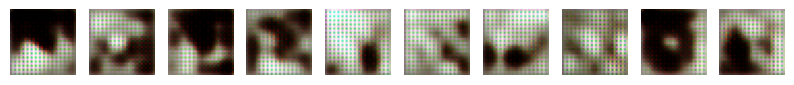

468/468 [==============================] - 22s 27ms/step - d_loss: 0.3956 - g_loss: 3.1918
Epoch 2/50
468/468 [==============================] - 12s 25ms/step - d_loss: 0.4192 - g_loss: 2.5110
Epoch 3/50
468/468 [==============================] - 12s 26ms/step - d_loss: 0.5306 - g_loss: 1.9688
Epoch 4/50
468/468 [==============================] - 13s 27ms/step - d_loss: 0.5513 - g_loss: 1.6056
Epoch 5/50
468/468 [==============================] - 13s 28ms/step - d_loss: 0.5627 - g_loss: 1.3273
Epoch 6/50
468/468 [==============================] - 12s 27ms/step - d_loss: 0.5766 - g_loss: 1.4652
Epoch 7/50
468/468 [==============================] - 12s 27ms/step - d_loss: 0.6188 - g_loss: 1.2471
Epoch 8/50
468/468 [==============================] - 13s 27ms/step - d_loss: 0.5966 - g_loss: 1.3209
Epoch 9/50
468/468 [==============================] - 13s 27ms/step - d_loss: 0.6213 - g_loss: 1.3508
Epoch 10/50
467/468 [============================>.] - ETA: 0s - d_loss: 0.6247 - g_loss: 1.3

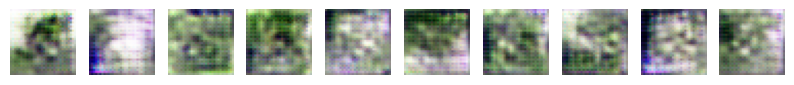

468/468 [==============================] - 13s 28ms/step - d_loss: 0.6246 - g_loss: 1.3142
Epoch 11/50
468/468 [==============================] - 13s 27ms/step - d_loss: 0.5967 - g_loss: 1.3767
Epoch 12/50
468/468 [==============================] - 13s 27ms/step - d_loss: 0.5160 - g_loss: 1.8290
Epoch 13/50
468/468 [==============================] - 13s 27ms/step - d_loss: 0.5817 - g_loss: 1.3030
Epoch 14/50
468/468 [==============================] - 13s 27ms/step - d_loss: 0.6086 - g_loss: 1.3363
Epoch 15/50
468/468 [==============================] - 13s 27ms/step - d_loss: 0.6104 - g_loss: 1.2725
Epoch 16/50
468/468 [==============================] - 13s 27ms/step - d_loss: 0.6037 - g_loss: 1.2270
Epoch 17/50
468/468 [==============================] - 13s 28ms/step - d_loss: 0.6180 - g_loss: 1.2839
Epoch 18/50
468/468 [==============================] - 13s 27ms/step - d_loss: 0.6020 - g_loss: 1.4129
Epoch 19/50
468/468 [==============================] - 13s 27ms/step - d_loss: 0.5650

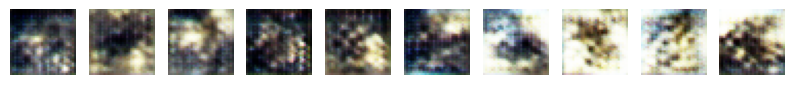

468/468 [==============================] - 13s 28ms/step - d_loss: 0.6050 - g_loss: 1.1026
Epoch 21/50
468/468 [==============================] - 13s 27ms/step - d_loss: 0.6196 - g_loss: 1.2302
Epoch 22/50
468/468 [==============================] - 13s 27ms/step - d_loss: 0.6122 - g_loss: 1.2787
Epoch 23/50
468/468 [==============================] - 13s 27ms/step - d_loss: 0.6100 - g_loss: 1.3494
Epoch 24/50
468/468 [==============================] - 13s 27ms/step - d_loss: 0.6142 - g_loss: 1.5671
Epoch 25/50
468/468 [==============================] - 13s 27ms/step - d_loss: 0.6046 - g_loss: 1.4472
Epoch 26/50
468/468 [==============================] - 13s 28ms/step - d_loss: 0.6276 - g_loss: 1.2595
Epoch 27/50
468/468 [==============================] - 13s 27ms/step - d_loss: 0.6164 - g_loss: 1.1863
Epoch 28/50
468/468 [==============================] - 13s 28ms/step - d_loss: 0.5896 - g_loss: 1.2117
Epoch 29/50
468/468 [==============================] - 13s 28ms/step - d_loss: 0.5604

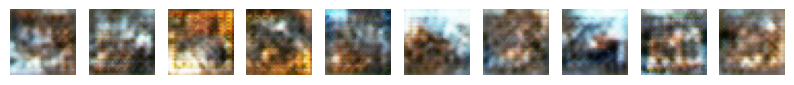

468/468 [==============================] - 13s 28ms/step - d_loss: 0.6057 - g_loss: 1.2782
Epoch 31/50
468/468 [==============================] - 13s 28ms/step - d_loss: 0.6002 - g_loss: 1.1317
Epoch 32/50
468/468 [==============================] - 13s 28ms/step - d_loss: 0.5980 - g_loss: 1.5031
Epoch 33/50
468/468 [==============================] - 13s 28ms/step - d_loss: 0.5900 - g_loss: 1.2314
Epoch 34/50
468/468 [==============================] - 13s 28ms/step - d_loss: 0.6048 - g_loss: 1.1984
Epoch 35/50
468/468 [==============================] - 13s 28ms/step - d_loss: 0.6333 - g_loss: 1.0436
Epoch 36/50
468/468 [==============================] - 13s 28ms/step - d_loss: 0.6248 - g_loss: 1.2821
Epoch 37/50
468/468 [==============================] - 13s 28ms/step - d_loss: 0.5837 - g_loss: 1.3979
Epoch 38/50
468/468 [==============================] - 13s 28ms/step - d_loss: 0.6090 - g_loss: 1.4179
Epoch 39/50
468/468 [==============================] - 13s 27ms/step - d_loss: 0.6194

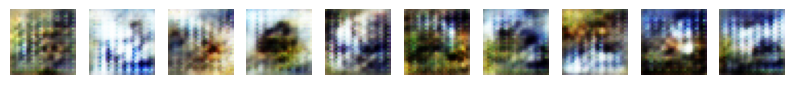

468/468 [==============================] - 13s 29ms/step - d_loss: 0.6294 - g_loss: 1.0687
Epoch 41/50
468/468 [==============================] - 13s 27ms/step - d_loss: 0.6560 - g_loss: 1.5321
Epoch 42/50
468/468 [==============================] - 13s 28ms/step - d_loss: 0.5807 - g_loss: 1.2768
Epoch 43/50
468/468 [==============================] - 13s 28ms/step - d_loss: 0.6200 - g_loss: 1.0272
Epoch 44/50
468/468 [==============================] - 13s 28ms/step - d_loss: 0.6314 - g_loss: 1.0575
Epoch 45/50
468/468 [==============================] - 13s 28ms/step - d_loss: 0.6299 - g_loss: 1.0994
Epoch 46/50
468/468 [==============================] - 13s 28ms/step - d_loss: 0.6414 - g_loss: 1.1902
Epoch 47/50
468/468 [==============================] - 13s 27ms/step - d_loss: 0.6286 - g_loss: 1.0864
Epoch 48/50
468/468 [==============================] - 13s 27ms/step - d_loss: 0.6362 - g_loss: 0.9740
Epoch 49/50
468/468 [==============================] - 13s 27ms/step - d_loss: 0.6349

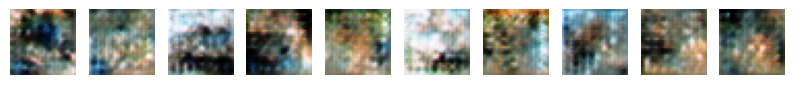

468/468 [==============================] - 13s 28ms/step - d_loss: 0.6445 - g_loss: 1.2530


In [ ]:
gan_er = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim, semilla_aleatoria=semilla_aleatoria)
gan_er.compile(
    d_optimizer=d_optimizer,
    g_optimizer=g_optimizer,
    loss_fn=loss_fn,
)

history = gan_er.fit(dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)])

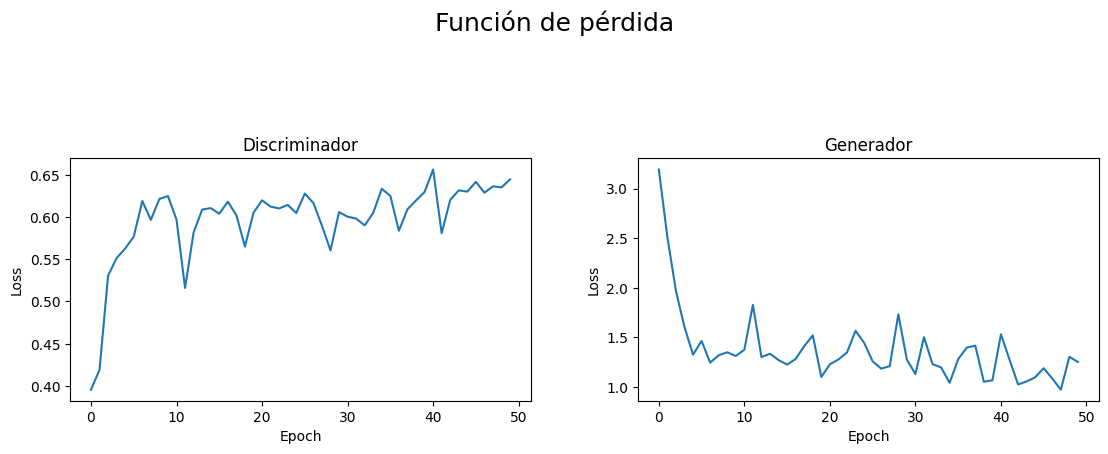

Pérdida discriminador: Min (0.396) Max (0.656) Media (0.597)
Pérdida generador: Min (0.974) Max (3.192) Media (1.373)


In [ ]:
plt_loss(history)

#### Resultados
<mark>\[Respuesta: Explicar los resultados obtenidos visualizando y compararlos con los obtenidos en la GAN sin *Experience replay*. \]</mark>

### GAN condicional
<mark>\[Respuesta: Explicar en qué consisten las GAN condicionales y qué resultados se esperan de estos modelos en relación al modelo original y al modelo con *Experience replay*. \]</mark>

En el siguiente [enlace](https://keras.io/examples/generative/conditional_gan/) se presenta un ejemplo de una CGAN sobre el conjunto de datos MNIST. Aunque este ejemplo no usa la API de Keras.

In [ ]:
num_classes = len(clases)
num_channels = 3
image_size = 32
discriminator_in_channels = num_channels + num_classes
generator_in_channels = latent_dim + num_classes
print(discriminator_in_channels, generator_in_channels)

13 110


In [ ]:
# Importamos las librerías necesarias para usar la API funcional de Keras
from tensorflow.keras.layers import Input, concatenate
from tensorflow.keras.models import Model

#### Discriminador
<mark>\[Respuesta: Explicar las adaptaciones que necesitará el discriminador para realizar la discriminación basado en la clase. \]</mark>

In [ ]:
# INICIO_RESPUESTA 7/7
# Requisitos: Implemente el generador para la GAN condicional, utilice la estructura del generador original y adáptela para que funcione con las etiquetas de clase
#             (utilice la variable «generator» para almacenar el generador tal y como se hizo en el caso base)
# Nota: se recomienda utilizar la API funcional para desarrollar este apartado.
def build_generator(latent_dim, num_classes, num_channels):
    # Input layers for noise vector and class labels
    class_label = Input(shape=(num_classes,))
    noise_input = Input(shape=(latent_dim,))

    # Concatenate noise and label embeddings
    concat_input = concatenate([class_label, noise_input], axis=-1)

    # Dense and reshape layer
    x = Dense(8 * 8 * (latent_dim + num_classes), activation="relu")(concat_input)
    x = Reshape((8, 8, (latent_dim + num_classes)))(x)
    x = BatchNormalization()(x)

    # Transposed convolutional layers
    x = Conv2DTranspose(64, kernel_size=4, strides=2, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)

    x = Conv2DTranspose(64, kernel_size=4, strides=2, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)

    # Output layer
    output = Conv2DTranspose(num_channels, kernel_size=3, strides=1, padding='same', activation='tanh')(x)

    # Model instantiation
    generator = Model(inputs=[class_label, noise_input], outputs=output, name="generator")
    return generator

# Define variables
latent_dim = 100

# Build generator
generator = build_generator(latent_dim, num_classes, num_channels)

# Print generator summary
generator.summary()
# FIN_RESPUESTA

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 10)]                 0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 concatenate_1 (Concatenate  (None, 110)                  0         ['input_3[0][0]',             
 )                                                                   'input_4[0][0]']             
                                                                                                  
 dense_2 (Dense)             (None, 7040)                 781440    ['concatenate_1[0][0]'

#### Generador
<mark>\[Respuesta: Explicar las adaptaciones que necesitará el generador para generar imágenes de una clase determinada. \]</mark>

In [ ]:
# INICIO_RESPUESTA 7/7
# Requisitos: Implemente el generador para la GAN condicional, utilice la estructura del generador original y adáptela para que funcione con las etiquetas de clase
#             (utilice la variable «generator» para almacenar el generador tal y como se hizo en el caso base)
# Nota: se recomienda utilizar la API funcional para desarrollar este apartado.
generator = keras.models.Sequential([
    keras.layers.InputLayer((generator_in_channels,)),
    tf.keras.layers.Dense(8 * 8 * generator_in_channels),
    tf.keras.layers.Reshape([8, 8, generator_in_channels]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(3,  kernel_size=3, strides=1, padding="same", activation="tanh"),
])

generator.summary()
# FIN_RESPUESTA

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 7040)              781440    
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 110)         0         
                                                                 
 batch_normalization_5 (Bat  (None, 8, 8, 110)         440       
 chNormalization)                                                
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 16, 16, 64)        112704    
 Transpose)                                                      
                                                                 
 batch_normalization_6 (Bat  (None, 16, 16, 64)        256       
 chNormalization)                                                
                                                      

#### Modelo

In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.experience_replay = []

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images[0])[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        generated_images = self.generator([real_images[1],random_latent_vectors])

        combined_images = tf.concat([generated_images, real_images[0]], axis=0)

        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        combined_labels = tf.concat([real_images[1], real_images[1]], axis=0)

        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as tape:
            predictions = self.discriminator([combined_images, combined_labels])
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            predictions = self.discriminator([self.generator([real_images[1],random_latent_vectors]), real_images[1]])
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))


        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

class GANMonitor(keras.callbacks.Callback):
    def __init__(self, y_train_enc = None, num_img=3, latent_dim=100, show_range=10,
                 enable_show=True, enable_save=False,
                 batch_size = 128):
        super().__init__()
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.show_range = show_range
        self.enable_show = enable_show
        self.enable_save = enable_save
        self.batch_size = batch_size
        self.y_train_enc = y_train_enc

    def on_epoch_end(self, epoch, logs=None):
        if ((epoch+1) % self.show_range) == 0 or epoch == 0:
          random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
          labels = self.y_train_enc[epoch:epoch+self.num_img]
          generated_images = self.model.generator([labels,random_latent_vectors])
          generated_images = (generated_images + 1) / 2.0

          generated_images.numpy()
          plt.figure(figsize=(self.num_img, 1))
          for i in range(self.num_img):
              img = keras.preprocessing.image.array_to_img(generated_images[i])
              if self.enable_show:
                plt.subplot(1, self.num_img, i + 1)
                plt.imshow(img, cmap="binary")
                plt.axis("off")
              if self.enable_save:
                img.save("generated_img_%03d_%d.png" % (epoch, i))
          if self.enable_show:
            plt.show()

In [ ]:
# Dado que ahora el generador y el discriminador utilizarán la clase de cada elemento, es necesario utilizar las etiquetas, transformándolas previamente a un array
all_labels_enc = keras.utils.to_categorical(all_labels, 10)
dataset = tf.data.Dataset.from_tensor_slices((all_imgs, all_labels_enc)).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

Epoch 1/50
  6/468 [..............................] - ETA: 11s - d_loss: 0.6604 - g_loss: 0.6780

468/468 [==============================] - ETA: 0s - d_loss: 0.4078 - g_loss: 2.6427

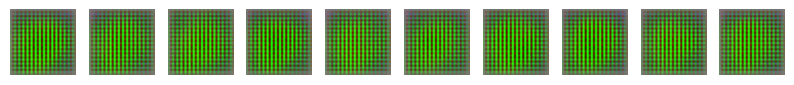

468/468 [==============================] - 21s 27ms/step - d_loss: 0.4078 - g_loss: 2.6427
Epoch 2/50
468/468 [==============================] - 13s 27ms/step - d_loss: 0.2492 - g_loss: 4.6595
Epoch 3/50
468/468 [==============================] - 13s 27ms/step - d_loss: 0.3744 - g_loss: 2.4928
Epoch 4/50
468/468 [==============================] - 12s 26ms/step - d_loss: 0.4166 - g_loss: 2.3307
Epoch 5/50
468/468 [==============================] - 12s 27ms/step - d_loss: 0.4178 - g_loss: 2.2967
Epoch 6/50
468/468 [==============================] - 13s 27ms/step - d_loss: 0.4271 - g_loss: 2.2691
Epoch 7/50
468/468 [==============================] - 13s 27ms/step - d_loss: 0.5507 - g_loss: 2.2917
Epoch 8/50
468/468 [==============================] - 13s 27ms/step - d_loss: 0.4093 - g_loss: 1.9586
Epoch 9/50
468/468 [==============================] - 13s 27ms/step - d_loss: 0.4461 - g_loss: 2.3679
Epoch 10/50
467/468 [============================>.] - ETA: 0s - d_loss: 0.4527 - g_loss: 3.2

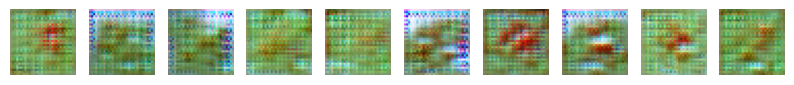

468/468 [==============================] - 13s 28ms/step - d_loss: 0.4525 - g_loss: 3.2509
Epoch 11/50
468/468 [==============================] - 13s 28ms/step - d_loss: 0.4295 - g_loss: 2.0315
Epoch 12/50
468/468 [==============================] - 13s 27ms/step - d_loss: 0.5350 - g_loss: 2.2074
Epoch 13/50
468/468 [==============================] - 13s 27ms/step - d_loss: 0.4923 - g_loss: 1.8061
Epoch 14/50
468/468 [==============================] - 13s 27ms/step - d_loss: 0.5690 - g_loss: 1.7066
Epoch 15/50
468/468 [==============================] - 13s 27ms/step - d_loss: 0.5837 - g_loss: 1.5776
Epoch 16/50
468/468 [==============================] - 13s 28ms/step - d_loss: 0.5424 - g_loss: 1.6243
Epoch 17/50
468/468 [==============================] - 13s 28ms/step - d_loss: 0.5754 - g_loss: 1.5285
Epoch 18/50
468/468 [==============================] - 13s 28ms/step - d_loss: 0.6375 - g_loss: 2.0567
Epoch 19/50
468/468 [==============================] - 13s 27ms/step - d_loss: 0.5838

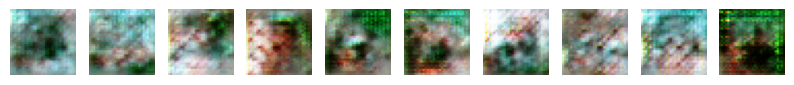

468/468 [==============================] - 13s 28ms/step - d_loss: 0.5522 - g_loss: 1.3345
Epoch 21/50
468/468 [==============================] - 13s 28ms/step - d_loss: 0.5835 - g_loss: 1.7878
Epoch 22/50
468/468 [==============================] - 13s 28ms/step - d_loss: 0.5121 - g_loss: 1.9401
Epoch 23/50
468/468 [==============================] - 13s 28ms/step - d_loss: 0.5463 - g_loss: 1.4262
Epoch 24/50
468/468 [==============================] - 13s 27ms/step - d_loss: 0.5719 - g_loss: 1.5371
Epoch 25/50
468/468 [==============================] - 13s 27ms/step - d_loss: 0.5032 - g_loss: 1.6176
Epoch 26/50
468/468 [==============================] - 13s 28ms/step - d_loss: 0.5596 - g_loss: 1.7104
Epoch 27/50
468/468 [==============================] - 13s 28ms/step - d_loss: 0.5254 - g_loss: 1.7497
Epoch 28/50
468/468 [==============================] - 13s 28ms/step - d_loss: 0.5282 - g_loss: 1.7860
Epoch 29/50
468/468 [==============================] - 13s 27ms/step - d_loss: 0.5158

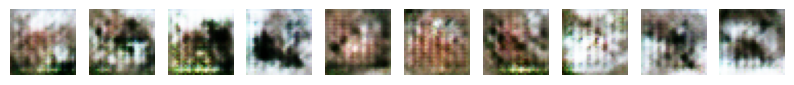

468/468 [==============================] - 13s 28ms/step - d_loss: 0.5307 - g_loss: 1.4871
Epoch 31/50
468/468 [==============================] - 13s 28ms/step - d_loss: 0.5469 - g_loss: 1.6149
Epoch 32/50
468/468 [==============================] - 13s 27ms/step - d_loss: 0.5658 - g_loss: 1.5159
Epoch 33/50
468/468 [==============================] - 13s 27ms/step - d_loss: 0.5479 - g_loss: 1.3186
Epoch 34/50
468/468 [==============================] - 13s 27ms/step - d_loss: 0.5760 - g_loss: 1.2864
Epoch 35/50
468/468 [==============================] - 13s 27ms/step - d_loss: 0.6122 - g_loss: 1.4616
Epoch 36/50
468/468 [==============================] - 13s 27ms/step - d_loss: 0.6094 - g_loss: 1.3637
Epoch 37/50
468/468 [==============================] - 13s 28ms/step - d_loss: 0.6107 - g_loss: 1.1098
Epoch 38/50
468/468 [==============================] - 13s 28ms/step - d_loss: 0.6218 - g_loss: 1.1990
Epoch 39/50
468/468 [==============================] - 13s 27ms/step - d_loss: 0.6609

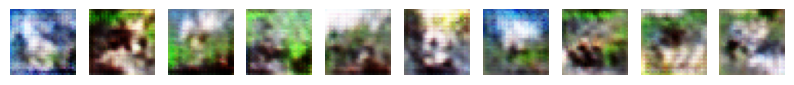

468/468 [==============================] - 13s 28ms/step - d_loss: 0.6236 - g_loss: 1.1404
Epoch 41/50
468/468 [==============================] - 13s 27ms/step - d_loss: 0.6274 - g_loss: 1.2903
Epoch 42/50
468/468 [==============================] - 13s 27ms/step - d_loss: 0.5941 - g_loss: 1.2748
Epoch 43/50
468/468 [==============================] - 13s 27ms/step - d_loss: 0.6267 - g_loss: 1.2042
Epoch 44/50
468/468 [==============================] - 13s 27ms/step - d_loss: 0.6110 - g_loss: 1.1213
Epoch 45/50
468/468 [==============================] - 13s 27ms/step - d_loss: 0.6806 - g_loss: 1.3675
Epoch 46/50
468/468 [==============================] - 13s 27ms/step - d_loss: 0.5670 - g_loss: 1.6235
Epoch 47/50
468/468 [==============================] - 13s 27ms/step - d_loss: 0.5246 - g_loss: 1.3080
Epoch 48/50
468/468 [==============================] - 13s 27ms/step - d_loss: 0.6151 - g_loss: 1.4825
Epoch 49/50
468/468 [==============================] - 13s 28ms/step - d_loss: 0.5844

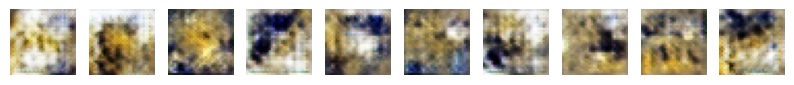

468/468 [==============================] - 13s 28ms/step - d_loss: 0.5271 - g_loss: 1.5107


In [ ]:
conditional_gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
conditional_gan.compile(
    d_optimizer=d_optimizer,
    g_optimizer=g_optimizer,
    loss_fn=loss_fn
)

history = conditional_gan.fit(dataset, epochs=epochs, callbacks=[GANMonitor(all_labels_enc,
                                                                num_img=10,
                                                                latent_dim=latent_dim)])

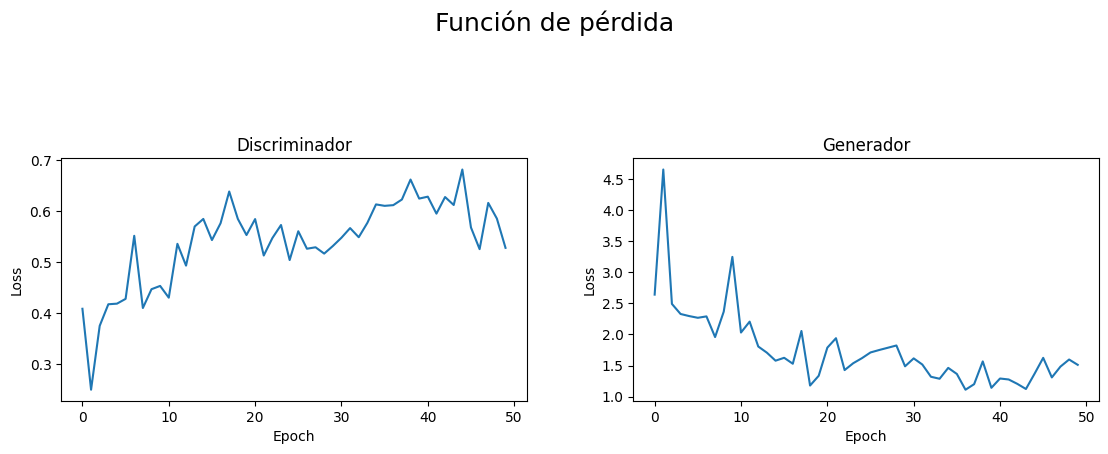

Pérdida discriminador: Min (0.249) Max (0.681) Media (0.539)
Pérdida generador: Min (1.110) Max (4.659) Media (1.757)


In [ ]:
plt_loss(history)

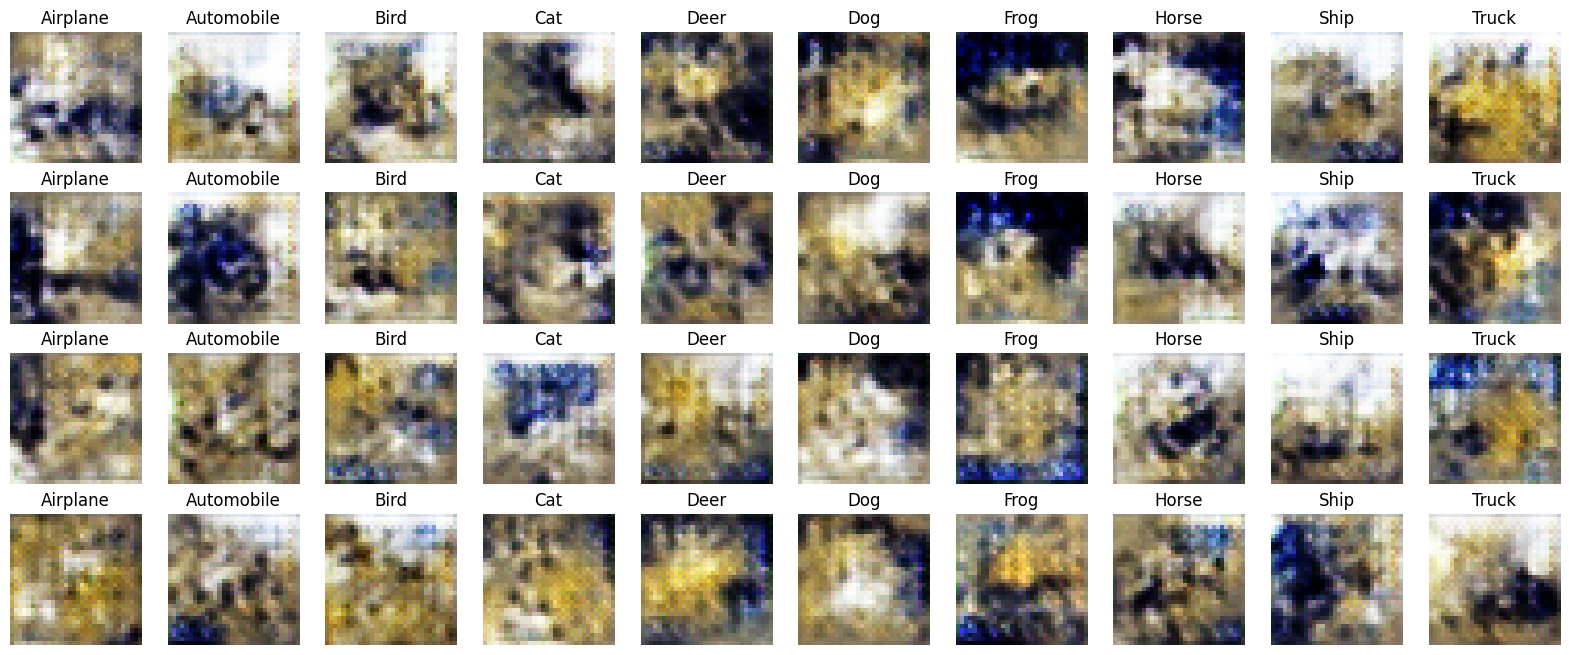

In [ ]:
classes_labels = keras.utils.to_categorical([x for x in range(10)] * 4, 10)

random_latent_vectors = tf.random.normal(shape=(len(classes_labels), latent_dim))
generated_images = conditional_gan.generator([classes_labels,random_latent_vectors])
generated_images = (generated_images + 1) / 2.0
# generated_images.numpy()
plt.figure(figsize=(20, 8))
plt.subplots_adjust(wspace=0.2, hspace=0.2)
pos = 1
classes_to_int = np.argmax(classes_labels, axis=-1)
for n in range(generated_images.shape[0]):
    plt.subplot(4, 10, pos)
    img = keras.preprocessing.image.array_to_img(generated_images[n])
    plt.imshow(img)
    plt.axis('off')
    plt.title(clases[classes_to_int[n]], size=12)
    pos += 1
plt.show()

#### Resultados
<mark>\[Respuesta: Explicar los resultados obtenidos visualizando y compararlos con los obtenidos en la GAN que se ha utilizado como base y la GAN con *Experience replay*. \]</mark>

### Conclusiones finales
<mark>\[Respuesta: Resumir el trabajo realizado y las conclusiones principales que se extraen del mismo. \]</mark>

### (Opcional) Cycle-GANs
<mark>\[Respuesta: Buscar información de las *Cycle GANs* y resumir su funcionamiento, haciendo especial énfasis en las novedades que introducen sobre las tipologías vistas en esta práctica . \]</mark>